**Importing Necessary Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

**MLP - Unbalanced Dataset**

In [2]:
# Load Dataset
df = pd.read_csv("../Datasets/Unbalanced_Binary.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,1
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,1
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,1
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,1
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,1


In [3]:
df['target'].value_counts()

target
1    437
0     80
Name: count, dtype: int64

In [4]:
# Splitting Data
X = df.drop(columns=["target"])  # Features
y = df["target"].values          # Target Variable

In [5]:
# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [8]:
# Create PyTorch Dataloader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1) 

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x)) 
        x = self.fc4(x)  
        return self.sigmoid(x) 

In [11]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=X_train.shape[1]).to(device)

In [12]:
device

device(type='cuda')

In [13]:
# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5) # L2 Regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning Rate Scheduler

In [14]:
# Training Loop with Early Stopping
epochs = 100
best_val_loss = float("inf")
patience = 10  # Stop if validation loss doesn't improve for 5 consecutive epochs
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    scheduler.step()
    
    # Compute Validation Loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor.to(device))
        val_loss = criterion(val_outputs, y_test_tensor.to(device)).item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/100], Loss: 0.6170, Val Loss: 0.5252
Epoch [2/100], Loss: 0.4748, Val Loss: 0.3518
Epoch [3/100], Loss: 0.3847, Val Loss: 0.2930
Epoch [4/100], Loss: 0.3426, Val Loss: 0.2525
Epoch [5/100], Loss: 0.2934, Val Loss: 0.2188
Epoch [6/100], Loss: 0.2495, Val Loss: 0.1863
Epoch [7/100], Loss: 0.2043, Val Loss: 0.1662
Epoch [8/100], Loss: 0.1723, Val Loss: 0.1425
Epoch [9/100], Loss: 0.1440, Val Loss: 0.1339
Epoch [10/100], Loss: 0.1120, Val Loss: 0.1267
Epoch [11/100], Loss: 0.0972, Val Loss: 0.1234
Epoch [12/100], Loss: 0.0988, Val Loss: 0.1217
Epoch [13/100], Loss: 0.0986, Val Loss: 0.1207
Epoch [14/100], Loss: 0.0869, Val Loss: 0.1192
Epoch [15/100], Loss: 0.0925, Val Loss: 0.1178
Epoch [16/100], Loss: 0.0941, Val Loss: 0.1163
Epoch [17/100], Loss: 0.0843, Val Loss: 0.1168
Epoch [18/100], Loss: 0.0893, Val Loss: 0.1172
Epoch [19/100], Loss: 0.0891, Val Loss: 0.1151
Epoch [20/100], Loss: 0.0809, Val Loss: 0.1138
Epoch [21/100], Loss: 0.0830, Val Loss: 0.1137
Epoch [22/100], Loss: 

In [15]:
# Model Evaluation
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor.to(device)).cpu().numpy()
    y_pred_binary = (y_pred_probs >= 0.5).astype(int)

In [16]:
# Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average="binary")
cm = confusion_matrix(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Precision: 0.9681, Recall: 1.0000, F1-Score: 0.9838


In [17]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[10  3]
 [ 0 91]]


(array([0.5, 1.5]), [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

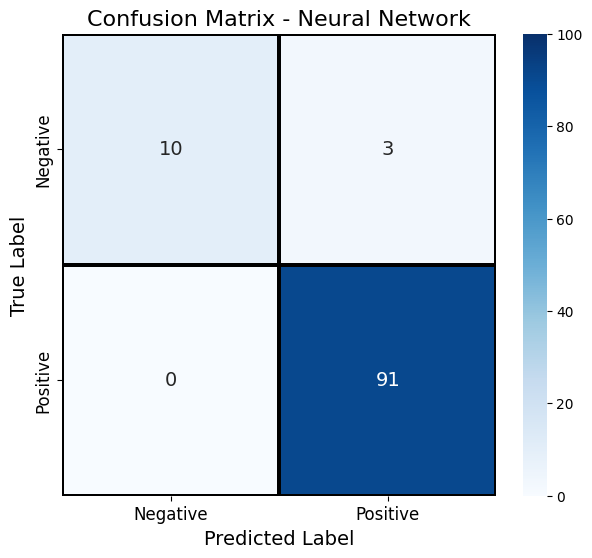

In [18]:
# Plot Confusion Matrix
plt.figure(figsize=(7,6))  # Increase figure size
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', 
                 linewidths=1.5, linecolor='black', 
                 annot_kws={"size": 14}, vmin=0, vmax=100,
                 xticklabels=['Negative', 'Positive'], 
                 yticklabels=['Negative', 'Positive'])


plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix - Neural Network", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [19]:
# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Compute Sensitivity & Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 1.0000
Specificity: 0.7692


In [20]:
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.9712
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.97      1.00      0.98        91

    accuracy                           0.97       104
   macro avg       0.98      0.88      0.93       104
weighted avg       0.97      0.97      0.97       104



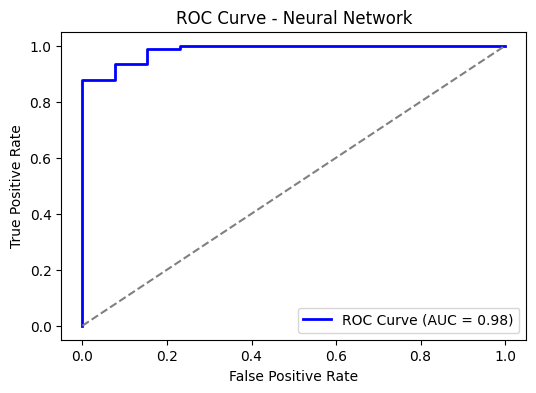

In [21]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend(loc="lower right")
plt.show()

**MLP - Balanced Dataset**

In [22]:
# Load Dataset
df = pd.read_csv("../Datasets/Balanced_Binary.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,1
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,1
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,1
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,1
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,1


In [23]:
df['target'].value_counts()

target
1    437
0    437
Name: count, dtype: int64

In [24]:
# Splitting Data
X = df.drop(columns=["target"])  # Features
y = df["target"].values          # Target Variable

In [25]:
# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [28]:
# Create PyTorch Dataloader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1) 

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x)) 
        x = self.fc4(x)  
        return self.sigmoid(x) 

In [30]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=X_train.shape[1]).to(device)

In [31]:
device

device(type='cuda')

In [32]:
# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5) # L2 Regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning Rate Scheduler

In [33]:
# Training Loop with Early Stopping
epochs = 100
best_val_loss = float("inf")
patience = 10  # Stop if validation loss doesn't improve for 5 consecutive epochs
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    scheduler.step()
    
    # Compute Validation Loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor.to(device))
        val_loss = criterion(val_outputs, y_test_tensor.to(device)).item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/100], Loss: 0.6526, Val Loss: 0.5701
Epoch [2/100], Loss: 0.4602, Val Loss: 0.2790
Epoch [3/100], Loss: 0.2209, Val Loss: 0.1228
Epoch [4/100], Loss: 0.1199, Val Loss: 0.0734
Epoch [5/100], Loss: 0.0856, Val Loss: 0.0530
Epoch [6/100], Loss: 0.0645, Val Loss: 0.0471
Epoch [7/100], Loss: 0.0496, Val Loss: 0.0434
Epoch [8/100], Loss: 0.0399, Val Loss: 0.0570
Epoch [9/100], Loss: 0.0445, Val Loss: 0.0409
Epoch [10/100], Loss: 0.0362, Val Loss: 0.0312
Epoch [11/100], Loss: 0.0252, Val Loss: 0.0301
Epoch [12/100], Loss: 0.0216, Val Loss: 0.0291
Epoch [13/100], Loss: 0.0259, Val Loss: 0.0292
Epoch [14/100], Loss: 0.0282, Val Loss: 0.0294
Epoch [15/100], Loss: 0.0188, Val Loss: 0.0301
Epoch [16/100], Loss: 0.0210, Val Loss: 0.0294
Epoch [17/100], Loss: 0.0188, Val Loss: 0.0288
Epoch [18/100], Loss: 0.0150, Val Loss: 0.0286
Epoch [19/100], Loss: 0.0175, Val Loss: 0.0283
Epoch [20/100], Loss: 0.0248, Val Loss: 0.0282
Epoch [21/100], Loss: 0.0181, Val Loss: 0.0283
Epoch [22/100], Loss: 

In [34]:
# Model Evaluation
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor.to(device)).cpu().numpy()
    y_pred_binary = (y_pred_probs >= 0.5).astype(int)

In [35]:
# Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average="binary")
cm = confusion_matrix(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Precision: 1.0000, Recall: 0.9765, F1-Score: 0.9881


In [36]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[90  0]
 [ 2 83]]


(array([0.5, 1.5]), [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

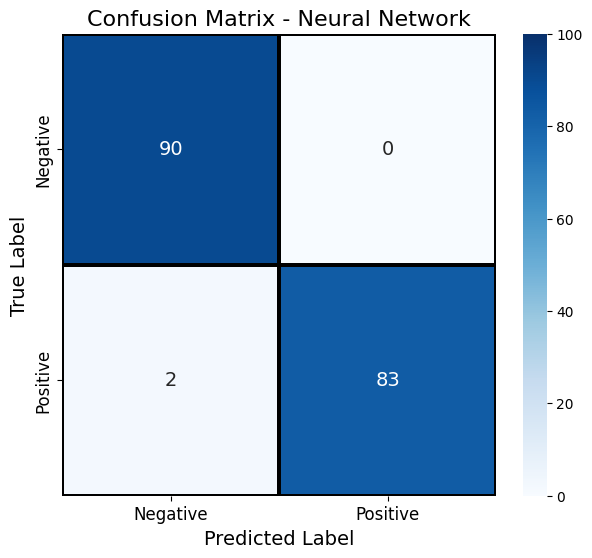

In [37]:
# Plot Confusion Matrix
plt.figure(figsize=(7,6))  # Increase figure size
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', 
                 linewidths=1.5, linecolor='black', 
                 annot_kws={"size": 14}, vmin=0, vmax=100,
                 xticklabels=['Negative', 'Positive'], 
                 yticklabels=['Negative', 'Positive'])


plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix - Neural Network", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [38]:
# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Compute Sensitivity & Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.9765
Specificity: 1.0000


In [39]:
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.9886
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        90
           1       1.00      0.98      0.99        85

    accuracy                           0.99       175
   macro avg       0.99      0.99      0.99       175
weighted avg       0.99      0.99      0.99       175



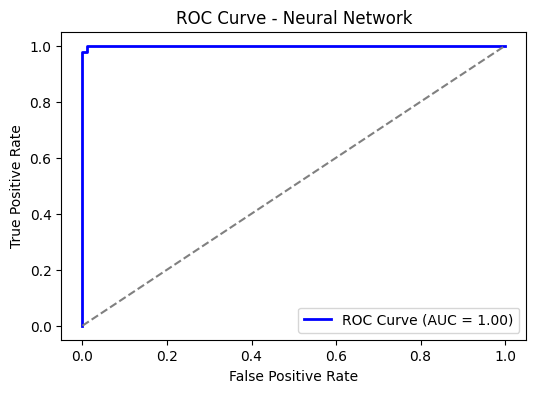

In [40]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend(loc="lower right")
plt.show()